# Компʼютерний практикум №9
Виконав студент групи ЗК-41мп Гломозда Костянтин

РОЗПІЗНАВАННЯ РУКОПИСНИХ ЧИСЕЛ ЗГОРТКОВОЮ НЕЙРОННОЮ МЕРЕЖЕЮ

# Завдання 1

Встановлюємо сіди

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Завантажуємо дані

In [168]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./data', download=True, train=False)

X_train = MNIST_train.data
y_train = MNIST_train.targets

X_test = MNIST_test.data
y_test = MNIST_test.targets
print(len(y_train), len(y_test))

60000 10000


Візуалізація

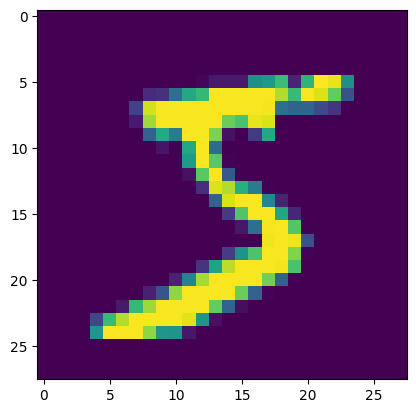

tensor(5)
torch.Size([60000, 1, 28, 28])


In [169]:
import matplotlib.pyplot as plt


plt.imshow(X_train[0, :, :])
plt.show()

print(y_train[0])
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
print(X_train.shape)

Будуємо мережу

In [170]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(
        in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Tanh -> ReLU
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
        in_channels=6, out_channels=16, kernel_size=5, padding=0)
        # Tanh -> ReLU
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x
    
lenet5 = LeNet5()

Навчання

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
# lr 1.0e-3 -> 1.0e-4
# Adam -> SGD
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-4)

batch_size = 100
epochs = 12
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        preds = lenet5.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()
    
    if epoch % (epochs // 10) == 0:
        test_preds = lenet5.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        print(f"Epoch: {epoch}/{epochs}, accuracy: {accuracy:.03f}, loss: {test_loss_history[-1]:.03f}")

# lenet5.forward(X_test)
print(f"Final accuracy: {test_accuracy_history[-1]:.03f}")
print(f"Final loss: {test_loss_history[-1]:.03f}")

# Обчислення дисперсії на тестовій вибірці
test_variance = test_preds.var(dim=0).mean().item()
print(f"Test variance: {test_variance:.03f}")

cuda
Epoch: 0/12, accuracy: 0.953, loss: 0.255
Epoch: 1/12, accuracy: 0.974, loss: 0.115
Epoch: 2/12, accuracy: 0.980, loss: 0.080
Epoch: 3/12, accuracy: 0.983, loss: 0.061
Epoch: 4/12, accuracy: 0.986, loss: 0.051
Epoch: 5/12, accuracy: 0.985, loss: 0.046
Epoch: 6/12, accuracy: 0.985, loss: 0.045
Epoch: 7/12, accuracy: 0.987, loss: 0.039
Epoch: 8/12, accuracy: 0.988, loss: 0.038
Epoch: 9/12, accuracy: 0.989, loss: 0.035
Epoch: 10/12, accuracy: 0.990, loss: 0.032
Epoch: 11/12, accuracy: 0.990, loss: 0.033
Final accuracy: 0.990
Final loss: 0.033
Test variance: 12.163


Візуалізація

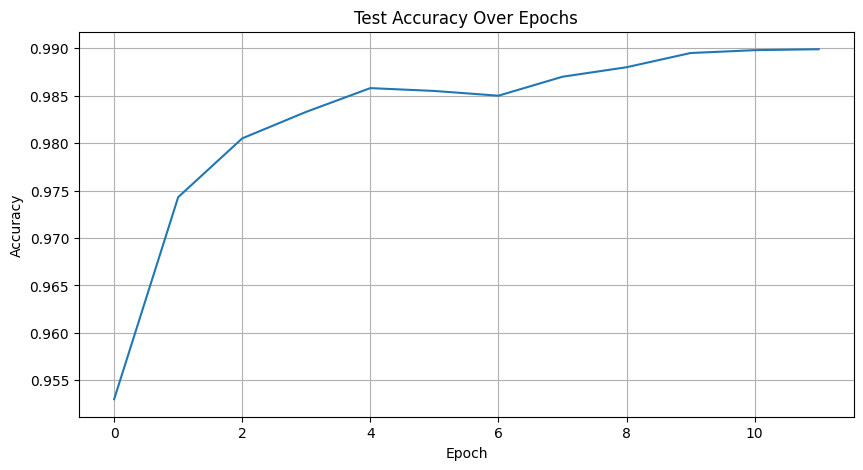

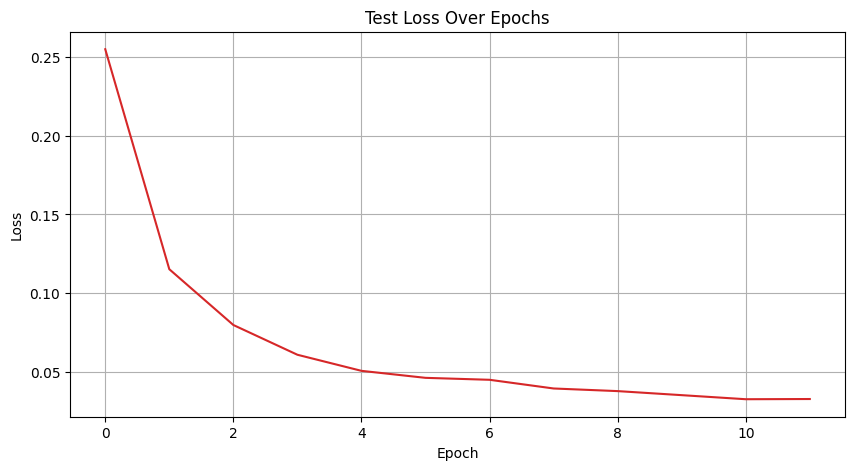

In [173]:
# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracy_history, color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(test_loss_history, color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.grid(True)
plt.show()

`Досягнуто точності 0.990`

a. Чи з'являється перенавчання при збільшенні кількості епох?

Так, приблизно після 8-12 епох.

b. Як додавання різних шарів впливає на швидкість навчання (які шари обробляються швидше: згорткові або повнозв'язні)?

Згорткові.

c. Проаналізуйте дисперсію цільової метрики від запуску до запуску.

Adam показав більшу дисперсію (12.1) через свою чутливість до початкових умов та параметрів, тоді як SGD дав значення 0.285.

d. Скільки запусків досить зробити, перед тим як стверджувати, що
одна архітектура краща за іншу?

Мінімум по 2 експеримента для кожної архітектури

# Завдання 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Параметри
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Завантаження та підготовка даних CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(CIFAR_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False)

print(CIFAR_train.classes)  # Виведення класів


Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Мережа з адаптацією під новий датасет

In [3]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(
        in_channels=3, out_channels=6, kernel_size=5, padding=0)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
        in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x
    
lenet5 = LeNet5()

Тренування

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
lenet5 = LeNet5().to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-4)

test_accuracy_history = []
test_loss_history = []
epochs = 20
# Навчання
for epoch in range(epochs):
    lenet5.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lenet5(images)
        loss_value = loss(outputs, labels)
        loss_value.backward()
        optimizer.step()

    lenet5.eval()
    test_correct = 0
    total_test_loss = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_outputs = lenet5(test_images)
            total_test_loss += loss(test_outputs, test_labels).item()
            _, predicted = torch.max(test_outputs.data, 1)
            test_correct += (predicted == test_labels).sum().item()

    test_loss_history.append(total_test_loss / len(test_loader))
    test_accuracy = 100 * test_correct / len(CIFAR_test)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{epochs}], Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss_history[-1]:.4f}')

# Підсумкові результати
print(f'Final Test Accuracy: {test_accuracy_history[-1]:.2f}%')
print(f'Final Test Loss: {test_loss_history[-1]:.4f}')

# Обчислення дисперсії на тестовій вибірці
test_variance = torch.var(torch.tensor(test_accuracy_history))
print(f"Test variance: {test_variance:.04f}")

cuda
Epoch [1/20], Test Accuracy: 33.82%, Test Loss: 1.8297
Epoch [2/20], Test Accuracy: 38.70%, Test Loss: 1.7021
Epoch [3/20], Test Accuracy: 40.90%, Test Loss: 1.6282
Epoch [4/20], Test Accuracy: 42.83%, Test Loss: 1.5795
Epoch [5/20], Test Accuracy: 43.88%, Test Loss: 1.5362
Epoch [6/20], Test Accuracy: 45.75%, Test Loss: 1.4914
Epoch [7/20], Test Accuracy: 47.15%, Test Loss: 1.4577
Epoch [8/20], Test Accuracy: 48.09%, Test Loss: 1.4412
Epoch [9/20], Test Accuracy: 49.85%, Test Loss: 1.4081
Epoch [10/20], Test Accuracy: 50.03%, Test Loss: 1.3867
Epoch [11/20], Test Accuracy: 50.83%, Test Loss: 1.3643
Epoch [12/20], Test Accuracy: 51.74%, Test Loss: 1.3455
Epoch [13/20], Test Accuracy: 52.00%, Test Loss: 1.3386
Epoch [14/20], Test Accuracy: 51.83%, Test Loss: 1.3342
Epoch [15/20], Test Accuracy: 52.56%, Test Loss: 1.3253
Epoch [16/20], Test Accuracy: 53.13%, Test Loss: 1.3075
Epoch [17/20], Test Accuracy: 53.96%, Test Loss: 1.2880
Epoch [18/20], Test Accuracy: 53.69%, Test Loss: 1.2

Візуалізація


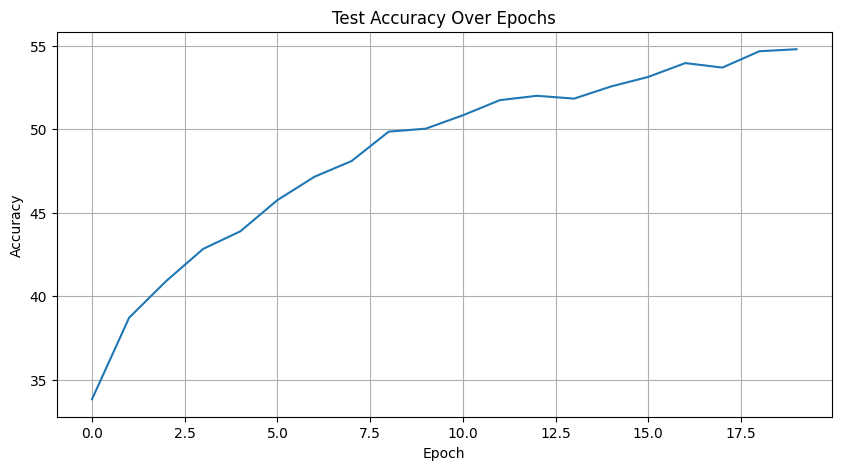

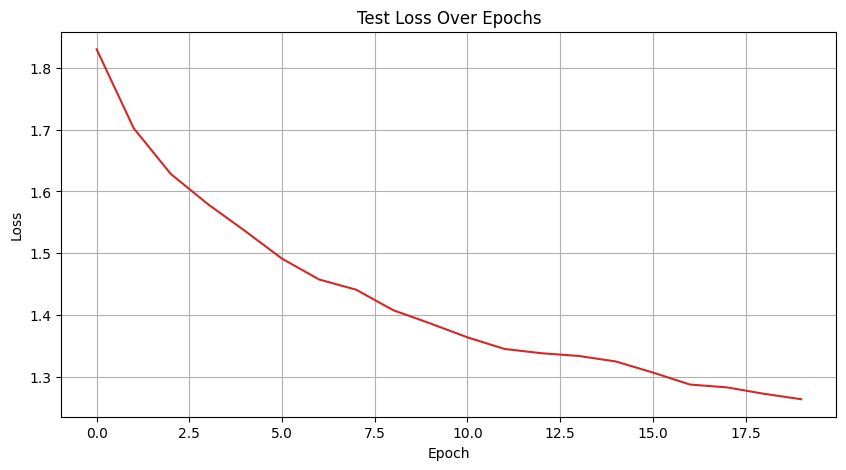

In [8]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracy_history, color='tab:blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(test_loss_history, color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.grid(True)
plt.show()

Для навчання можна взяти більше епох або змінити гіперпараметри для кращого результату

# Завдання 3

Підберіть правильні параметри паденгу (в коментарі після
кожного завдання вказано, який розмір тензору на виході повинен
бути)

In [9]:
import torch

N = 4
C = 3
C_out = 10
H = 8
W = 16
x = torch.ones((N, C, H, W))

# First example
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=1)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

# Second example
out = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=2)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

# Third example
out = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=3)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

# Fourth example
out = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=4)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

# Fifth example
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(1, 2))(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

# Sixth example
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=(7, 7))(x)
print(out.shape) # torch.Size([4, 10, 22, 30])

# Seventh example
out = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=0)(x)
print(out.shape) # torch.Size([4, 10, 7, 15])

# Eighth example
out = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=1)(x)
print(out.shape) # torch.Size([4, 10, 9, 17])

torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 20, 28])
torch.Size([4, 10, 5, 13])
torch.Size([4, 10, 9, 17])
